# SE TIM 2021: Cloud Optimized Data Session
## The Power of Cloud Optimized Data: From dataset to time series in 5 lines of Python

## Background and Inspiration:

This notebook describes the python-based Zarr time series approach as part of the TRT-43 time series technology study. [What we wanted to show with this option...] This notebook was adapted from the [Pangeo AGU Ocean Sciences 2020 tutorial](https://github.com/pangeo-gallery/osm2020tutorial) with credits below:

### Credits: Tutorial development
Dr. Chelle Gentemann - Twitter - Farallon Institute

Lucas Sterzinger - Twitter - University of California, Davis
  
### Compute Resources
This notebook was developed and run using an AWS m5.2xlarge instance as this is what was utilized in the Pangeo workshop via their OHW JupyterHub. This has 8 vCPU and 32 GB memory. 

# Dataset used: Multi-Scale Ultra High Resolution (MUR) Sea Surface Temperature (SST)

Found from the AWS Open Registry [MUR SST](https://registry.opendata.aws/mur/)
[ADD INFO ON NATIVE COLLECTION VS ZARR]

 
 
 
 

-------------------------------------------------------

![](./awsmur.png)



More information on Zarr, from the original notebook authors referenced above: 

Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.

Fast - Zarr is fast because all the metadata is consolidated into a .json file. Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

Simple - Filenames? Who needs them? Who cares? Not I. Simply point your read routine to the data directory.

Metadata - all you want!

## Import Libraries

You may need to pip install these libraries depending on your python environment

In [1]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from statistics import mean
from statistics import stdev
# make datasets display nicely
xr.set_options(display_style="html")  

import dask
from dask.distributed import performance_report, Client, progress

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Creates a mapping between your computer and the s3 bucket.  This isn't necessary if the Zarr file is stored locally.

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


### Simplest test case:
Single Grid Cell; 100 time slices

In [3]:
t0 = time.time()
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2003-01-01','2003-04-10'),
                                        lat  = 40,
                                        lon  = -130 
                                       ).load()

wall_time = time.time() - t0
print (wall_time, "seconds wall time")
ds_sst 

6.270727157592773 seconds wall time


,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 100)>
array([285.659  , 285.73898, 285.69098, 285.64398, 285.478  , 285.541  ,
       285.589  , 286.098  , 286.11798, 286.05   , 285.817  , 285.99   ,
       286.154  , 286.326  , 286.348  , 286.218  , 286.20398, 286.261  ,
       286.25598, 286.082  , 285.943  , 285.974  , 286.037  , 285.99   ,
       285.822  , 285.50998, 285.675  , 285.718  , 285.72998, 285.94598,
       285.828  , 285.779  , 285.891  , 285.719  , 285.763  , 285.637  ,
       285.391  , 285.11798, 285.155  , 285.184  , 285.192  , 285.113  ,
       284.938  , 284.86398, 285.042  , 285.086  , 284.987  , 285.123  ,
       285.19   , 285.149  , 285.11   , 285.21298, 285.24298, 285.336  ,
       285.414  , 285.36   , 285.031  , 284.741  , 285.02798, 285.082  ,
       285.039  , 284.97598, 285.099  , 285.109  , 284.98898, 284.90198,
       284.85   , 285.168  , 285.189  , 285.349  , 285.19598, 285.043  ,
       284.878  , 284.64798, 284.754  , 284.867  , 284.87698, 284.753  ,
       284.81   , 284.813  , 284.86   , 284.839  , 284.762  , 284.925  ,
       285.198  , 285.069  , 285.451  , 285.953  , 286.16998, 285.981  ,
       285.775  , 284.95398, 284.807  , 284.82098, 284.69098, 284.514  ,
       284.43298, 284.474  , 284.567  , 284.74   ], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 -130.0
  * time     (time) datetime64[ns] 2003-01-01T09:00:00 ... 2003-04-10T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

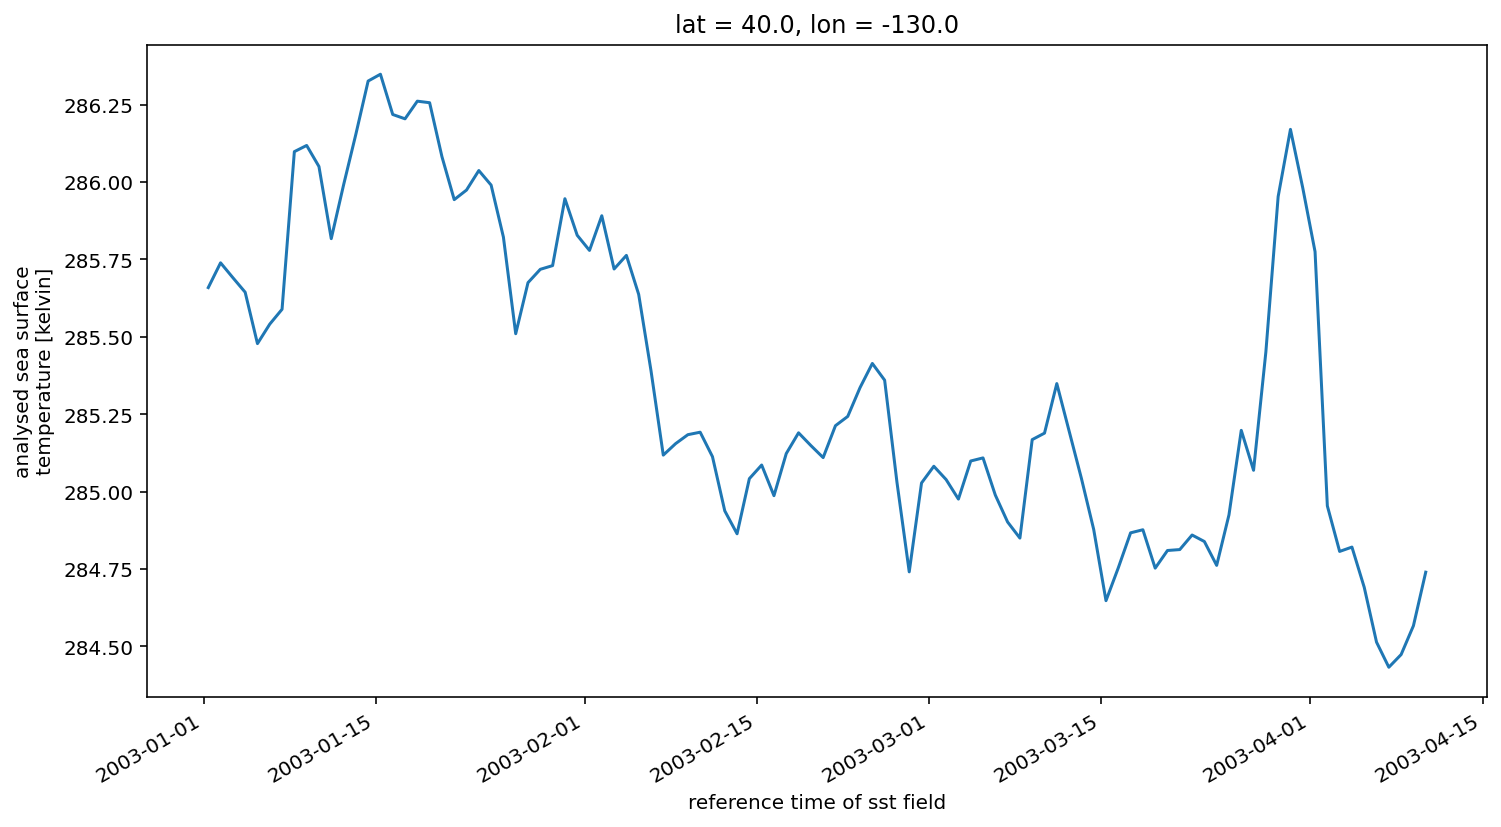

In [5]:
sst_timeseries.plot()

### More complex:
10x10 grid cells; 6443 time slices (across the entire temporal extent of the Zarr store from 2002-06-01 to 2020-01-20). 

In [6]:

t0 = time.time()
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2002-05-31','2021-08-12'),
                                        lat  = slice(39.905,40),
                                        lon  = slice(-130,-129.91) 
                                       ).load()

wall_time = time.time() - t0
print (wall_time, "seconds wall time")
ds_sst 

7.471420764923096 seconds wall time


,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.19 TiB,245.78 MiB
Shape,"(6443, 17999, 36000)","(6443, 100, 100)"
Count,64801 Tasks,64800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
sst_timeseries

<xarray.DataArray 'analysed_sst' (time: 6443, lat: 10, lon: 10)>
array([[[286.421  , 286.413  , 286.405  , ..., 286.376  , 286.37   ,
         286.363  ],
        [286.409  , 286.40298, 286.397  , ..., 286.383  , 286.379  ,
         286.373  ],
        [286.402  , 286.399  , 286.397  , ..., 286.40298, 286.4    ,
         286.39398],
        ...,
        [286.417  , 286.434  , 286.45398, ..., 286.538  , 286.539  ,
         286.53   ],
        [286.422  , 286.443  , 286.46698, ..., 286.56   , 286.554  ,
         286.539  ],
        [286.425  , 286.448  , 286.475  , ..., 286.58798, 286.573  ,
         286.547  ]],

       [[285.92398, 285.901  , 285.883  , ..., 285.88098, 285.887  ,
         285.893  ],
        [285.89398, 285.87698, 285.86398, ..., 285.893  , 285.906  ,
         285.916  ],
        [285.878  , 285.866  , 285.858  , ..., 285.917  , 285.93698,
         285.95398],
...
        [285.554  , 285.54898, 285.544  , ..., 285.505  , 285.494  ,
         285.483  ],
        [285.548  , 285.542  , 285.535  , ..., 285.48898, 285.477  ,
         285.465  ],
        [285.53998, 285.533  , 285.524  , ..., 285.472  , 285.46   ,
         285.447  ]],

       [[285.573  , 285.589  , 285.604  , ..., 285.642  , 285.646  ,
         285.65   ],
        [285.574  , 285.58798, 285.6    , ..., 285.632  , 285.63498,
         285.638  ],
        [285.58   , 285.59   , 285.599  , ..., 285.625  , 285.62698,
         285.628  ],
        ...,
        [285.63998, 285.632  , 285.625  , ..., 285.594  , 285.589  ,
         285.58398],
        [285.654  , 285.642  , 285.632  , ..., 285.589  , 285.582  ,
         285.57498],
        [285.666  , 285.652  , 285.638  , ..., 285.583  , 285.574  ,
         285.56598]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 39.91 39.92 39.93 39.94 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float32 -130.0 -130.0 -130.0 -130.0 ... -129.9 -129.9 -129.9
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

(array([ 7933., 86708., 99047., 91908., 79244., 67972., 84942., 84630.,
        33867.,  8049.]),
 array([282.80298, 283.9615 , 285.12   , 286.27847, 287.43698, 288.5955 ,
        289.754  , 290.9125 , 292.07098, 293.2295 , 294.388  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

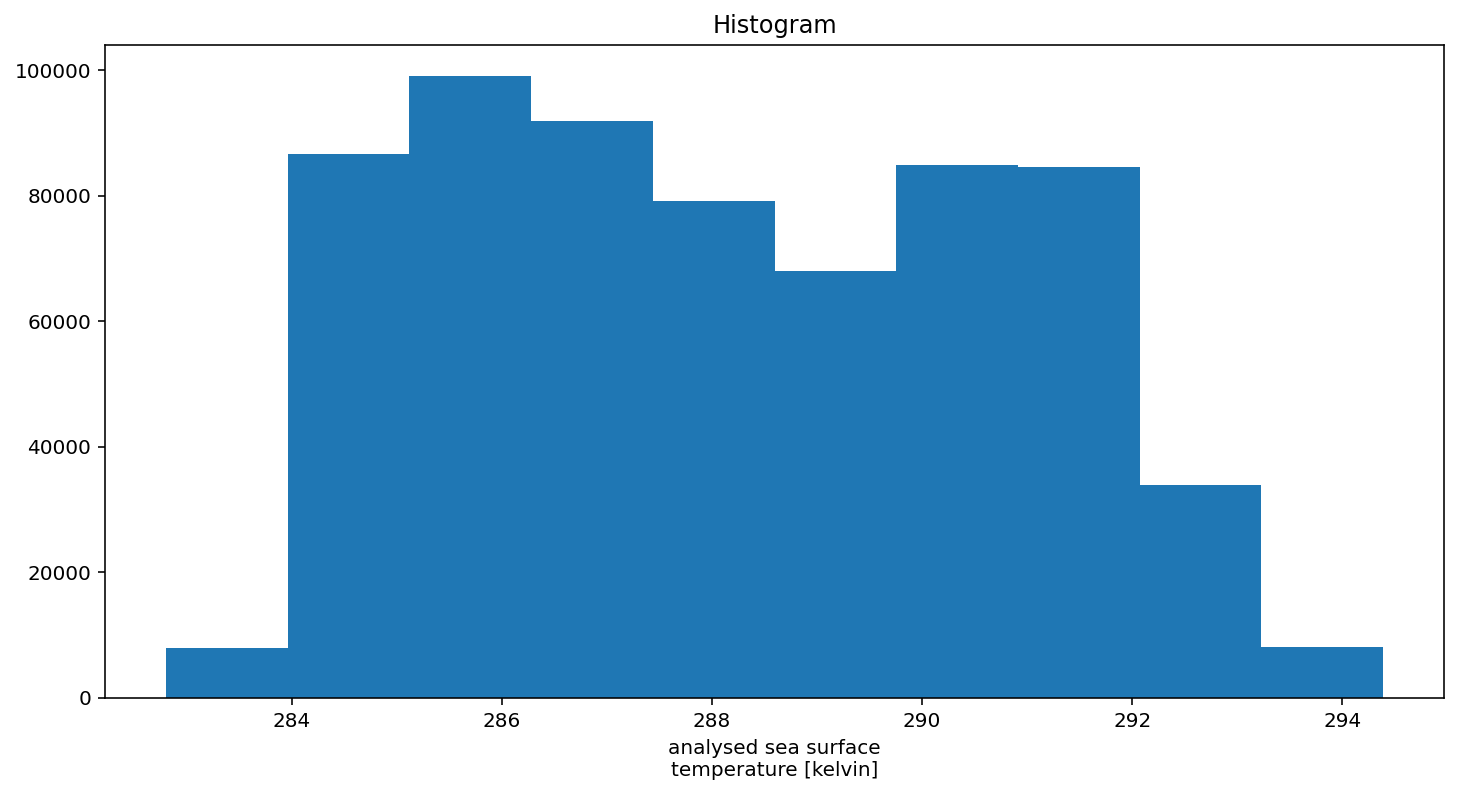

In [8]:
sst_timeseries.plot()